<a href="https://colab.research.google.com/github/text123580/ml20200716/blob/master/yolo_face.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
FOLDER_PATH = '/content/drive/My Drive/AI_04/勞動部/week9/keras-yolo3-blood-cell'
FOLDER_PATH1 = '/content/drive/My Drive/AI_04'
import sys
sys.path.append(FOLDER_PATH)

In [ ]:
import numpy as np
import keras.backend as K
from keras.layers import Input, Lambda
from train import yolo_body, get_anchors, create_model, get_classes
# from yolo import YOLO
import cv2
from PIL import Image
import matplotlib.pyplot as plt
from glob import glob
import os

Using TensorFlow backend.


In [ ]:
# -*- coding: utf-8 -*-
"""
Class definition of YOLO_v3 style detection model on image and video
"""

import colorsys
import os
from timeit import default_timer as timer

import numpy as np
from keras import backend as K
from keras.models import load_model
from keras.layers import Input
from PIL import Image, ImageFont, ImageDraw

from yolo3.model import yolo_eval, yolo_body, tiny_yolo_body
from yolo3.utils import letterbox_image
import os
from keras.utils import multi_gpu_model

class YOLO(object):
    _defaults = {
#         "model_path": 'ep051-loss79.393-val_loss76.696.h5',
#        "anchors_path": 'model_data/yolo_anchors.txt',
#         "classes_path": 'model_data/aoi_classes.txt',
#         "score" : 0.3,
        "score" : 0.2,
#         "iou" : 0.45,
        "iou" : 0.2,
        "model_image_size" : (416, 416),
        "gpu_num" : 1,
    }

    @classmethod
    def get_defaults(cls, n):
        if n in cls._defaults:
            return cls._defaults[n]
        else:
            return "Unrecognized attribute name '" + n + "'"

    def __init__(self, model_path=None, classes_path=None, anchors_path=None,**kwargs):
        self.__dict__.update(self._defaults) # set up default values
        self.__dict__.update(kwargs) # and update with user overrides
        self.model_path = model_path
        self.classes_path = classes_path
        self.anchors_path = anchors_path
        self.class_names = self._get_class()
        self.anchors = self._get_anchors()
        self.sess = K.get_session()
        self.boxes, self.scores, self.classes = self.generate()

    def _get_class(self):
        classes_path = self.classes_path
        with open(classes_path) as f:
            class_names = f.readlines()
        class_names = [c.strip() for c in class_names]
        return class_names

    def _get_anchors(self):
        anchors_path = self.anchors_path
#        anchors_path = os.path.expanduser(self.anchors_path)
        with open(anchors_path) as f:
            anchors = f.readline()
        anchors = [float(x) for x in anchors.split(',')]
        return np.array(anchors).reshape(-1, 2)

    def generate(self):
        model_path = self.model_path
        assert model_path.endswith('.h5'), 'Keras model or weights must be a .h5 file.'

        # Load model, or construct model and load weights.
        num_anchors = len(self.anchors)
        num_classes = len(self.class_names)
        is_tiny_version = num_anchors==6 # default setting
        try:
            self.yolo_model = load_model(model_path, compile=False)
        except:
            self.yolo_model = tiny_yolo_body(Input(shape=(None,None,3)), num_anchors//2, num_classes) \
                if is_tiny_version else yolo_body(Input(shape=(None,None,3)), num_anchors//3, num_classes)
            self.yolo_model.load_weights(self.model_path) # make sure model, anchors and classes match
        else:
            assert self.yolo_model.layers[-1].output_shape[-1] == \
                num_anchors/len(self.yolo_model.output) * (num_classes + 5), \
                'Mismatch between model and given anchor and class sizes'

        print('{} model, anchors, and classes loaded.'.format(model_path))

        # Generate colors for drawing bounding boxes.
        hsv_tuples = [(x / len(self.class_names), 1., 1.)
                      for x in range(len(self.class_names))]
        self.colors = list(map(lambda x: colorsys.hsv_to_rgb(*x), hsv_tuples))
        self.colors = list(
            map(lambda x: (int(x[0] * 255), int(x[1] * 255), int(x[2] * 255)),
                self.colors))
        np.random.seed(10101)  # Fixed seed for consistent colors across runs.
        np.random.shuffle(self.colors)  # Shuffle colors to decorrelate adjacent classes.
        np.random.seed(None)  # Reset seed to default.

        # Generate output tensor targets for filtered bounding boxes.
        self.input_image_shape = K.placeholder(shape=(2, ))
        if self.gpu_num>=2:
            self.yolo_model = multi_gpu_model(self.yolo_model, gpus=self.gpu_num)
        boxes, scores, classes = yolo_eval(self.yolo_model.output, self.anchors,
                len(self.class_names), self.input_image_shape,
                score_threshold=self.score, iou_threshold=self.iou)
        return boxes, scores, classes

    def detect_image(self, image):
        start = timer()

        if self.model_image_size != (None, None):
            assert self.model_image_size[0]%32 == 0, 'Multiples of 32 required'
            assert self.model_image_size[1]%32 == 0, 'Multiples of 32 required'
            boxed_image = letterbox_image(image, tuple(reversed(self.model_image_size)))
        else:
            new_image_size = (image.width - (image.width % 32),
                              image.height - (image.height % 32))
            boxed_image = letterbox_image(image, new_image_size)
        image_data = np.array(boxed_image, dtype='float32')

        print(image_data.shape)
        image_data /= 255.
        image_data = np.expand_dims(image_data, 0)  # Add batch dimension.

        out_boxes, out_scores, out_classes = self.sess.run(
            [self.boxes, self.scores, self.classes],
            feed_dict={
                self.yolo_model.input: image_data,
                self.input_image_shape: [image.size[1], image.size[0]],
                K.learning_phase(): 0
            })

        print('111Found {} boxes for {}'.format(len(out_boxes), 'img'))
        font = ImageFont.load_default()
#        font = ImageFont.truetype(font='font/FiraMono-Medium.otf',
#                    size=np.floor(3e-2 * image.size[1] + 0.5).astype('int32'))
        thickness = (image.size[0] + image.size[1]) // 300

        #最佳目标框对应分数
        best_score = 0.0

        #最终返回的目标框位置信息 
        final_top = final_left = final_bottom = final_right= 0

        for i, c in reversed(list(enumerate(out_classes))):
            predicted_class = self.class_names[c]
            box = out_boxes[i]
            score = out_scores[i]

            label = '{} {:.2f}'.format(predicted_class, score)
            draw = ImageDraw.Draw(image)
            label_size = draw.textsize(label, font=font)

            top, left, bottom, right = box
            top = max(0, np.floor(top + 0.5).astype('int32'))
            left = max(0, np.floor(left + 0.5).astype('int32'))
            bottom = min(image.size[1], np.floor(bottom + 0.5).astype('int32'))
            right = min(image.size[0], np.floor(right + 0.5).astype('int32'))

            #保留分数最高的目标框
            if score > best_score:
                best_score = score
                final_top = top
                final_left = left
                final_bottom = bottom
                final_right= right


            print(label, (left, top), (right, bottom))

            if top - label_size[1] >= 0:
                text_origin = np.array([left, top - label_size[1]])
            else:
                text_origin = np.array([left, top + 1])

            # My kingdom for a good redistributable image drawing library.
            for i in range(thickness):
                draw.rectangle(
                    [left + i, top + i, right - i, bottom - i],
                    outline=self.colors[c])
#            draw.rectangle(
#                [tuple(text_origin), tuple(text_origin + label_size)],
#                fill=self.colors[c])
#            draw.text(text_origin, label, fill=(0, 0, 0), font=font)
            del draw

        end = timer()
        print(end - start)
        #return image
        return  image, final_left, final_top, final_right, final_bottom

    def close_session(self):
        self.sess.close()

def detect_video(yolo, video_path, output_path=""):
    import cv2
    vid = cv2.VideoCapture(video_path)
    if not vid.isOpened():
        raise IOError("Couldn't open webcam or video")
    video_FourCC    = int(vid.get(cv2.CAP_PROP_FOURCC))
    video_fps       = vid.get(cv2.CAP_PROP_FPS)
    video_size      = (int(vid.get(cv2.CAP_PROP_FRAME_WIDTH)),
                        int(vid.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    isOutput = True if output_path != "" else False
    if isOutput:
        print("!!! TYPE:", type(output_path), type(video_FourCC), type(video_fps), type(video_size))
        out = cv2.VideoWriter(output_path, video_FourCC, video_fps, video_size)
    accum_time = 0
    curr_fps = 0
    fps = "FPS: ??"
    prev_time = timer()
    while True:
        return_value, frame = vid.read()
        image = Image.fromarray(frame)
        image = yolo.detect_image(image)
        result = np.asarray(image)
        curr_time = timer()
        exec_time = curr_time - prev_time
        prev_time = curr_time
        accum_time = accum_time + exec_time
        curr_fps = curr_fps + 1
        if accum_time > 1:
            accum_time = accum_time - 1
            fps = "FPS: " + str(curr_fps)
            curr_fps = 0
        cv2.putText(result, text=fps, org=(3, 15), fontFace=cv2.FONT_HERSHEY_SIMPLEX,
                    fontScale=0.50, color=(255, 0, 0), thickness=2)
        cv2.namedWindow("result", cv2.WINDOW_NORMAL)
        cv2.imshow("result", result)
        if isOutput:
            out.write(result)
        if cv2.waitKey(1) & 0xFF == ord('q'):
            break
    yolo.close_session()



In [ ]:
# COCO pre-trained
classes_path = os.path.join(FOLDER_PATH1, 'Model/wider_classes.txt')
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors_path = os.path.join(FOLDER_PATH1, 'Model/wider_anchors.txt')
anchors = get_anchors(anchors_path)

yolo_f = YOLO(model_path=os.path.join(FOLDER_PATH1, 'Model/wider_face_yolo.h5'),classes_path=classes_path,anchors_path=anchors_path)


Instructions for updating:
If using Keras pass *_constraint arguments to layers.
/content/drive/My Drive/AI_04/Model/wider_face_yolo.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


(1024, 1024) (416, 416)
(416, 416, 3)
111Found 1 boxes for img
face 1.00 (409, 225) (729, 582)
7.462374397999952


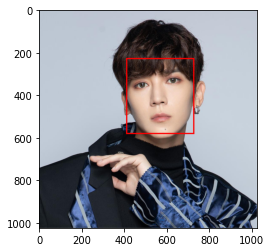

In [ ]:
path = os.path.join(FOLDER_PATH1,'0814.jpg')
#print(path)
image = Image.open(path)
image1,left,top,right,bottom=yolo_f.detect_image(image)
# r_image = yolo_f.detect_image(image)
# r_image.show()
# plt.figure(figsize=(10,10))
# plt.imshow(r_image)

#img1 = image.copy()
# img1 = crop_image(img1, 409, 225, 729, 582);

# cropped = image1.crop((left, top, right, bottom))
# plt.figure("detect")
# plt.figure("cropped")
# plt.figure(figsize=(10,10))
plt.imshow(image1)
# plt.imshow(cropped)
plt.show()
# cropped.save(FOLDER_PATH1+"/aaa.jpg")

In [ ]:
# COCO pre-trained
classes_path = os.path.join(FOLDER_PATH, 'model_data/coco_classes.txt')
class_names = get_classes(classes_path)
num_classes = len(class_names)
anchors_path = os.path.join(FOLDER_PATH, 'model_data/yolo_anchors.txt')
anchors = get_anchors(anchors_path)

yolo = YOLO(model_path=os.path.join(FOLDER_PATH, 'yolo_weights.h5'),
            classes_path=classes_path,
            anchors_path=anchors_path)

/content/drive/My Drive/AI_04/勞動部/week9/keras-yolo3-blood-cell/yolo_weights.h5 model, anchors, and classes loaded.


/content/drive/My Drive/AI_04/0814.jpg
(1024, 1024) (416, 416)
(416, 416, 3)
111Found 1 boxes for img
person 1.00 (182, 47) (992, 978)
2.694268526999963


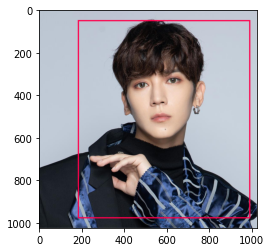

In [ ]:
path = os.path.join(FOLDER_PATH1, '0814.jpg')
print(path)
image = Image.open(path)
r_image,left,top,right,bottom=yolo.detect_image(image)
r_image.show()
# plt.figure(figsize=(10,10))
plt.imshow(r_image)